In [1]:
import requests
import pandas as pd

#ignore all warnings
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta, date, datetime
from dateutil.relativedelta import relativedelta
from dateutil import rrule
import time
import itertools
import matplotlib.pyplot as plt

#### Function returns list of end of month dates

In [2]:
def daterange(d1, d2):
    # count numbero f months between two dates, excluding the final date
    monthcount = (d2.year - d1.year) * 12 + d2.month - d1.month

    # convert start month to the first of next months
    d1 = d1 + relativedelta(months=1)
    d1 = datetime(d1.year, d1.month, 1)
    months = list(rrule.rrule(rrule.MONTHLY, dtstart=d1, count=monthcount))
    months = [i - timedelta(1) for i in months]
    return months

## Read fiscal textfile for the specified date
#### If available, returns the, end of month and fiscal year to date total marketable and nonmarketable issues  (from Table III-A, Public Debt Transactions).

In [3]:
def readtxt(date):
    str_date = date.strftime('%y%m%d')
    f = str_date + '00.txt'
    url = 'https://fsapps.fiscal.treasury.gov/dts/files/' + f
    # print(url)
    r = requests.get(url, allow_redirects=True)
    open('data/' + f, 'wb').write(r.content)

    temp = open('data/'+f, 'r')

    # First we find the start and end lines of the table of interest
    start_table_line = 0
    for line in temp:
        if 'TABLE III-A  Public Debt Transactions' in line: #start of table is found
            #reopen file
            temp = open('data/' + f, 'r')
            end_table_line = start_table_line + 7
            for table_line in itertools.islice(temp, start_table_line+7, None):
                if '__________' in table_line:
                    break
                end_table_line += 1
            break
        start_table_line += 1

    #reopen the file
    temp = open('data/' + f, 'r')
    nonmarketable_ind = False # indicator for nonmarketable debt.
    marketable = [0, 0]
    nonmarketable = [0, 0]
    total_issues = []
    for line in itertools.islice(temp, start_table_line, end_table_line):
        line = line.replace('\n', '')
        line = line.replace(',', '')
        line = line.replace('$', '')

        if 'Total Issues' in line:
            digits = [int(s) for s in line.split() if s.isdigit()]
            total_issues = digits[1:]
            break
        if 'Nonmarketable:' in line:
            nonmarketable_ind = True
            continue

        digits = [int(s) for s in line.split() if s.isdigit()]
        if len(digits) == 3:
            if not nonmarketable_ind:
                marketable = [sum(x) for x in zip(marketable, digits[1:])]
                continue
            nonmarketable = [sum(x) for x in zip(nonmarketable, digits[1:])]

    return marketable, nonmarketable, total_issues

# Initialisation and start

In [4]:
start_date = datetime(2005, 6, 1)
end_date = date.today()
dates = daterange(start_date, end_date)


# x = readtxt(start_date)
marketable = pd.DataFrame(index = dates, columns=['MtD', 'YtD'])
nonmarketable = pd.DataFrame(index = dates, columns=['MtD', 'YtD'])
total = pd.DataFrame(index = dates, columns=['MtD', 'YtD'])
for single_date in dates:
    count = 0
    start = time.time()
    datefinder = True
    
    while datefinder:
        print(single_date)
        try:
            output = readtxt(single_date)
            marketable.loc[single_date] = output[0]
            nonmarketable.loc[single_date] = output[1]
            total.loc[single_date] = output[2]
            datefinder = False
        # If an error occurs, try one date earlier
        except:
            #print('error at ' + str(single_date))
            single_date = single_date - timedelta(days=1)
            count += 1
            # try maximum of 6 dates, otherwise just go to the next month (this should only happen is there are no txtfiles available)
            if count > 6:
                break
    print(single_date.strftime('%B %Y') + ' completed, '+ str(round(time.time() - start, 2))+'s')


marketable = marketable.sort_index().dropna().astype(float)
nonmarketable = nonmarketable.sort_index().dropna().astype(float)
total = total.sort_index().dropna().astype(float)


2005-06-30 00:00:00
June 2005 completed, 0.68s
2005-07-31 00:00:00
2005-07-30 00:00:00
2005-07-29 00:00:00
July 2005 completed, 1.73s
2005-08-31 00:00:00
August 2005 completed, 0.64s
2005-09-30 00:00:00
September 2005 completed, 0.69s
2005-10-31 00:00:00
October 2005 completed, 0.65s
2005-11-30 00:00:00
November 2005 completed, 0.66s
2005-12-31 00:00:00
2005-12-30 00:00:00
December 2005 completed, 1.19s
2006-01-31 00:00:00
January 2006 completed, 0.69s
2006-02-28 00:00:00
February 2006 completed, 0.66s
2006-03-31 00:00:00
2006-03-30 00:00:00
March 2006 completed, 1.22s
2006-04-30 00:00:00
2006-04-29 00:00:00
2006-04-28 00:00:00
April 2006 completed, 1.74s
2006-05-31 00:00:00
May 2006 completed, 0.69s
2006-06-30 00:00:00
June 2006 completed, 0.66s
2006-07-31 00:00:00
July 2006 completed, 0.67s
2006-08-31 00:00:00
August 2006 completed, 0.69s
2006-09-30 00:00:00
2006-09-29 00:00:00
September 2006 completed, 1.19s
2006-10-31 00:00:00
October 2006 completed, 0.66s
2006-11-30 00:00:00
Novem

2016-04-29 00:00:00
April 2016 completed, 1.22s
2016-05-31 00:00:00
May 2016 completed, 0.68s
2016-06-30 00:00:00
2016-06-29 00:00:00
June 2016 completed, 1.21s
2016-07-31 00:00:00
2016-07-30 00:00:00
2016-07-29 00:00:00
July 2016 completed, 1.75s
2016-08-31 00:00:00
August 2016 completed, 0.67s
2016-09-30 00:00:00
September 2016 completed, 0.7s
2016-10-31 00:00:00
October 2016 completed, 0.68s
2016-11-30 00:00:00
November 2016 completed, 0.67s
2016-12-31 00:00:00
2016-12-30 00:00:00
December 2016 completed, 1.26s
2017-01-31 00:00:00
January 2017 completed, 0.69s
2017-02-28 00:00:00
February 2017 completed, 0.69s
2017-03-31 00:00:00
March 2017 completed, 0.67s
2017-04-30 00:00:00
2017-04-29 00:00:00
2017-04-28 00:00:00
April 2017 completed, 1.77s
2017-05-31 00:00:00
May 2017 completed, 0.67s
2017-06-30 00:00:00
June 2017 completed, 0.67s
2017-07-31 00:00:00
July 2017 completed, 0.67s
2017-08-31 00:00:00
August 2017 completed, 0.69s
2017-09-30 00:00:00
2017-09-29 00:00:00
September 2017

# Marketable Issues
### Consists among others of US Treasury bills, notes, bonds, TIPS

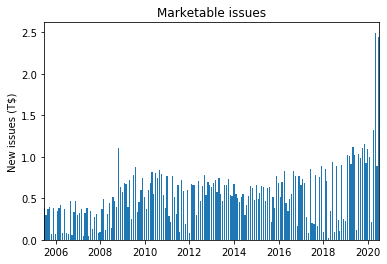

In [9]:
fig, ax = plt.subplots()
# marketable issues plot
ax.bar(marketable.index, marketable['MtD'] / 1000 / 1000 , width=20)
ax.xaxis_date()
plt.xlim(marketable.index[0], marketable.index[-1])
plt.ylabel('New issues (T$)')
plt.title('Marketable issues')
plt.show()

# Nonmarketable Issues
### Consists mostly of government account series (intergovernmental debt)

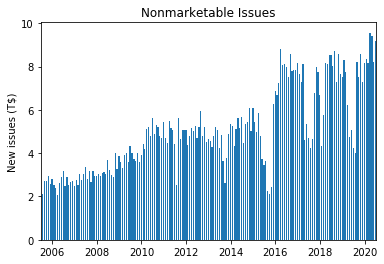

In [6]:
fig, ax = plt.subplots()
#non marketable issues plot
ax.bar(nonmarketable.index, nonmarketable['MtD'] / 1000 / 1000 , width=20)
ax.xaxis_date()
plt.xlim(nonmarketable.index[0], nonmarketable.index[-1])
plt.ylabel('New issues (T$)')
plt.title('Nonmarketable Issues')
plt.show()

# Total Issues

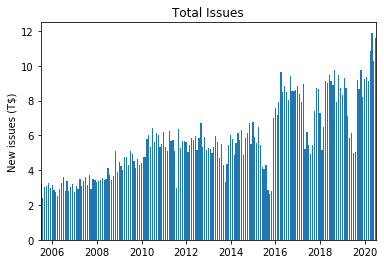

In [7]:
fig, ax = plt.subplots()
#non marketable issues plot
ax.bar(total.index, total['MtD'] / 1000 / 1000 , width=20)
ax.xaxis_date()
plt.xlim(total.index[0], total.index[-1])
plt.ylabel('New issues (T$)')
plt.title('Total Issues')
plt.show()